<a href="https://colab.research.google.com/github/magenta/ddsp/blob/master/ddsp/colab/tutorials/1_synths_and_effects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


##### Copyright 2020 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");





In [ ]:
# Copyright 2020 Google LLC. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# DDSP Synths and Effects

This notebook demonstrates the use of several of the Synths and Effects Processors in the DDSP library. While the core functions are also directly accessible through `ddsp.core`, using Processors is the preferred API for end-2-end training. 

As demonstrated in the [0_processors.ipynb](colab/tutorials/0_processors.ipynb) tutorial, Processors contain the necessary nonlinearities and preprocessing in their `get_controls()` method to convert generic neural network outputs into valid processor controls, which are then converted to signal by `get_signal()`. The two methods are called in series by `__call__()`.

While each processor is capable of a wide range of expression, we focus on simple examples here for clarity.

In [2]:
#@title Install and import dependencies

# %tensorflow_version 2.x
# !pip install -qU ddsp

# Ignore a bunch of deprecation warnings
import warnings
warnings.filterwarnings("ignore")

import ddsp
# import ddsp.training
# from ddsp.colab.colab_utils import (play, record, specplot, upload, 
#                                     DEFAULT_SAMPLE_RATE)
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

# IMPORTS MINE:
import sounddevice as sd
import time as stime


DEFAULT_SAMPLE_RATE = 16000 # general sound frequecy
sample_rate = DEFAULT_SAMPLE_RATE  # 16000 
sd.default.samplerate  = sample_rate # defult samplerate for sounddevice library
sd.default.channels = 1


In [27]:
### my Functions:
def playsound(inputsound):
    if len(inputsound) == 1:
        sd.play(inputsound[0], DEFAULT_SAMPLE_RATE)
        stime.sleep(len(inputsound[0])/DEFAULT_SAMPLE_RATE)
        sd.stop()
    else:
        sd.play(inputsound, DEFAULT_SAMPLE_RATE)
        stime.sleep(len(inputsound)/DEFAULT_SAMPLE_RATE)
        sd.stop()


def Myspecplot(inputsound):
    if len(inputsound)==1:
        plot = plt.figure(figsize=(4, 4))
        powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(inputsound[0], Fs=DEFAULT_SAMPLE_RATE)
        plt.xlabel('Time')
        plt.ylabel('Frequency')
        return plot   
    else:
        plot = plt.figure(figsize=(4, 4))
        powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(inputsound, Fs=DEFAULT_SAMPLE_RATE)
        plt.xlabel('Time')
        plt.ylabel('Frequency')
        return plot

    
# record sound and returen one arrry object
def recorder(duration=5):
    #duration = 5  # seconds
    # defult sample rate is 1600
    rec_audio = sd.rec(int(duration * sd.default.samplerate))
    sd.wait()
    audio = []
    for i in rec_audio:
        audio.append(i[0])
    audio = np.array(audio) 
    return audio

# Synths

Synthesizers, located in `ddsp.synths`, take network outputs and produce a signal (usually used as audio). 

## Additive

The additive synthesizer models a sound as a linear combination of harmonic sinusoids. Amplitude envelopes are generated with 50% overlapping hann windows. The final audio is cropped to `n_samples`.

Inputs:
* `amplitudes`: Amplitude envelope of the synthesizer output.
* `harmonic_distribution`: Normalized amplitudes of each harmonic.
* `frequencies`: Frequency in Hz of base oscillator.

In [4]:
n_frames = 1000
hop_size = 64
n_samples = n_frames * hop_size

# Amplitude [batch, n_frames, 1].
# Make amplitude linearly decay over time.
amps = np.linspace(1.0, -3.0, n_frames)
amps = amps[np.newaxis, :, np.newaxis]

# Harmonic Distribution [batch, n_frames, n_harmonics].
# Make harmonics decrease linearly with frequency.
n_harmonics = 20
harmonic_distribution = np.ones([n_frames, 1]) * np.linspace(1.0, -1.0, n_harmonics)[np.newaxis, :]
harmonic_distribution = harmonic_distribution[np.newaxis, :, :]

# Fundamental frequency in Hz [batch, n_frames, 1].
f0_hz = 440.0 * np.ones([1, n_frames, 1])

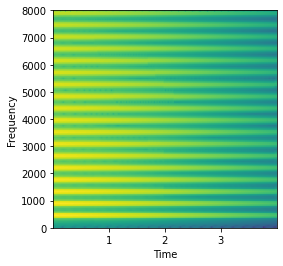

In [5]:
# Create synthesizer object.
additive_synth = ddsp.synths.Additive(n_samples=n_samples,
                                      scale_fn=ddsp.core.exp_sigmoid,
                                      sample_rate=sample_rate)

# Generate some audio.
audio = additive_synth(amps, harmonic_distribution, f0_hz)

# Listen.
playsound(audio)
plt_1 = Myspecplot(audio)
plt_1.show()

## Filtered Noise



The filtered noise synthesizer is a subtractive synthesizer that shapes white noise with a series of time-varying filter banks. 

Inputs:
* `magnitudes`: Amplitude envelope of each filter bank (linearly spaced from 0Hz to the Nyquist frequency).

In [6]:
n_frames = 250
n_frequencies = 1000
n_samples = 64000

# Bandpass filters, [n_batch, n_frames, n_frequencies].
magnitudes = [tf.sin(tf.linspace(0.0, w, n_frequencies)) for w in np.linspace(8.0, 80.0, n_frames)]
magnitudes = 0.5 * tf.stack(magnitudes)**4.0
magnitudes = magnitudes[tf.newaxis, :, :]

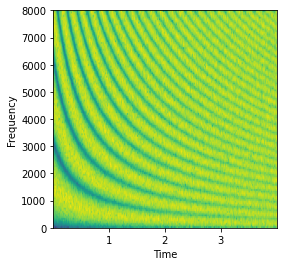

In [7]:
# Create synthesizer object.
filtered_noise_synth = ddsp.synths.FilteredNoise(n_samples=n_samples, 
                                                 scale_fn=None)

# Generate some audio.
audio = filtered_noise_synth(magnitudes)

# Listen.
playsound(audio)
plt_2 = Myspecplot(audio)
plt_2.show()

## Wavetable

The wavetable synthesizer generates audio through interpolative lookup from small chunks of waveforms (wavetables) provided by the network. In principle, it is very similar to the `Additive` synth, but with a parameterization in the waveform domain and generation using linear interpolation vs. cumulative summation of sinusoid phases.

Inputs:
* `amplitudes`: Amplitude envelope of the synthesizer output.
* `wavetables`: A series of wavetables that are interpolated to cover n_samples.
* `frequencies`: Frequency in Hz of base oscillator.

In [8]:
n_samples = 64000
n_wavetable = 2048
n_frames = 100

# Amplitude [batch, n_frames, 1].
amps = tf.linspace(0.5, 1e-3, n_frames)[tf.newaxis, :, tf.newaxis]

# Fundamental frequency in Hz [batch, n_frames, 1].
f0_hz = 110 * tf.linspace(1.5, 1, n_frames)[tf.newaxis, :, tf.newaxis]

# Wavetables [batch, n_frames, n_wavetable].
# Sin wave
wavetable_sin = tf.sin(tf.linspace(0.0, 2.0 * np.pi, n_wavetable))
wavetable_sin = wavetable_sin[tf.newaxis, tf.newaxis, :]

# Square wave
wavetable_square = tf.cast(wavetable_sin > 0.0, tf.float32) * 2.0 - 1.0

# Combine them and upsample to n_frames.
wavetables = tf.concat([wavetable_square, wavetable_sin], axis=1)
wavetables = ddsp.core.resample(wavetables, n_frames)

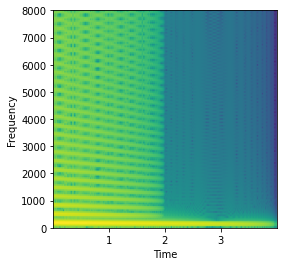

In [9]:
# Create synthesizer object.
wavetable_synth = ddsp.synths.Wavetable(n_samples=n_samples,
                                        sample_rate=sample_rate,
                                        scale_fn=None)

# Generate some audio.
audio = wavetable_synth(amps, wavetables, f0_hz)

# Listen, notice the aliasing artifacts from linear interpolation.
playsound(audio)
plt_3 = Myspecplot(audio)
plt_3.show()

# Effects

Effects, located in `ddsp.effects` are different in that they take network outputs to transform a given audio signal. Some effects, such as Reverb, optionally have trainable parameters of their own.

## Reverb

There are several types of reverberation processors in ddsp.

* Reverb
* ExpDecayReverb
* FilteredNoiseReverb

Unlike other processors, reverbs also have the option to treat the impulse response as a 'trainable' variable, and not require it from network outputs. This is helpful for instance if the room environment is the same for the whole dataset. To make the reverb trainable, just pass the kwarg `trainable=True` to the constructor

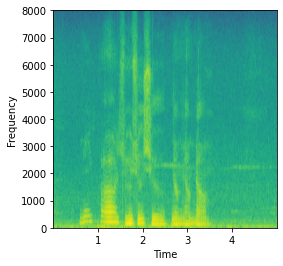

In [28]:
#@markdown Record or Upload Audio

record_or_upload = "Record" #@param ["Record", "Upload (.mp3 or .wav)"]

record_seconds =   5#@param {type:"number", min:1, max:10, step:1}

if record_or_upload == "Record":
    audio = recorder()

# print(type(audio))
# print(len(audio))
# print(audio)

audio = audio[np.newaxis, :]
plt_4 = Myspecplot(audio)
plt_4.show()
playsound(audio)

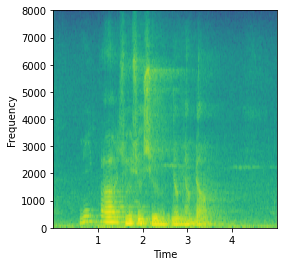

In [29]:
# Let's just do a simple exponential decay reverb.
reverb = ddsp.effects.ExpDecayReverb(reverb_length=48000)

gain = [[-2.0]]
decay = [[2.0]]
# gain: Linear gain of impulse response. Scaled by self._gain_scale_fn.
# decay: Exponential decay coefficient. The final impulse response is
#          exp(-(2 + exp(decay)) * time) where time goes from 0 to 1.0 over the
#          reverb_length samples.

audio_out = reverb(audio, gain, decay)

# Listen.
Myspecplot(audio_out)
playsound(audio_out)

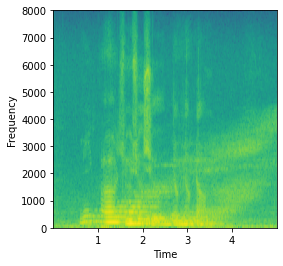

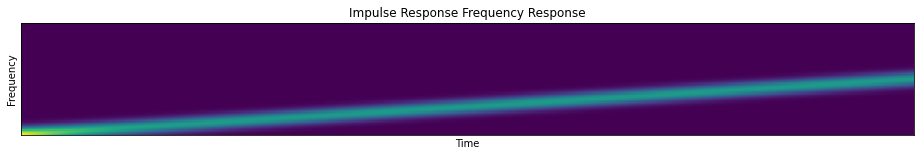

In [30]:
# Let's the filtered noise reverb can be quite expressive.
reverb = ddsp.effects.FilteredNoiseReverb(reverb_length=48000,
                                          scale_fn=None)

# Rising gaussian filtered band pass.
n_frames = 1000
n_frequencies = 100

frequencies = np.linspace(0, sample_rate / 2.0, n_frequencies)
center_frequency = 4000.0 * np.linspace(0, 1.0, n_frames)
width = 500.0
gauss = lambda x, mu: 2.0 * np.pi * width**-2.0 * np.exp(- ((x - mu) / width)**2.0)

# Actually make the magnitudes.
magnitudes = np.array([gauss(frequencies, cf) for cf in center_frequency])
magnitudes = magnitudes[np.newaxis, ...]
magnitudes /= magnitudes.sum(axis=-1, keepdims=True) * 5

# Apply the reverb.
audio_out = reverb(audio, magnitudes)

# Listen.
Myspecplot(audio_out)
playsound(audio_out)
plt.matshow(np.rot90(magnitudes[0]), aspect='auto')
plt.title('Impulse Response Frequency Response')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.xticks([])
_ = plt.yticks([])

## FIR Filter

Linear time-varying finite impulse response (LTV-FIR) filters are a broad class of filters that can vary over time.

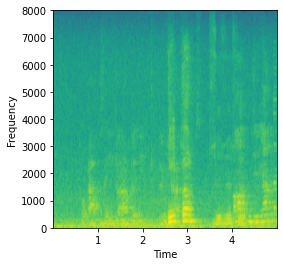

In [31]:
#@markdown Record or Upload Audio

record_or_upload = "Record" #@param ["Record", "Upload (.mp3 or .wav)"]

record_seconds =   5#@param {type:"number", min:1, max:10, step:1}

if record_or_upload == "Record":
    audio = recorder()
# else:
  # Load audio sample here (.mp3 or .wav3 file)
  # Just use the first file.
#   filenames, audios = upload()
#   audio = audios[0]

# Add batch dimension
audio = audio[np.newaxis, :]

# Listen.
Myspecplot(audio)
playsound(audio)

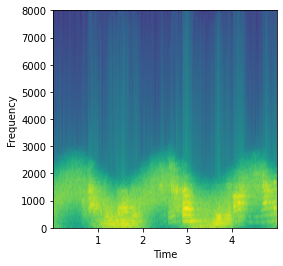

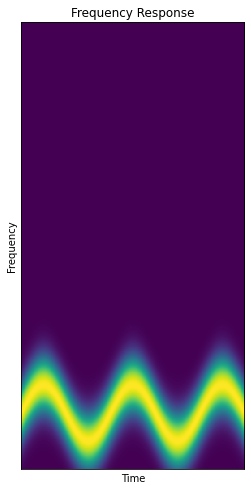

In [33]:
# Let's make an oscillating gaussian bandpass filter.
fir_filter = ddsp.effects.FIRFilter(scale_fn=None)

# Make up some oscillating gaussians.
n_seconds = audio.size / sample_rate
frame_rate = 100  # Hz
n_frames = int(n_seconds * frame_rate)
n_samples = int(n_frames * sample_rate / frame_rate)
audio_trimmed = audio[:, :n_samples]

n_frequencies = 1000
frequencies = np.linspace(0, sample_rate / 2.0, n_frequencies)

lfo_rate = 0.5  # Hz
n_cycles = n_seconds * lfo_rate
center_frequency = 1000 + 500 * np.sin(np.linspace(0, 2.0*np.pi*n_cycles, n_frames))
width = 500.0
gauss = lambda x, mu: 2.0 * np.pi * width**-2.0 * np.exp(- ((x - mu) / width)**2.0)


# Actually make the magnitudes.
magnitudes = np.array([gauss(frequencies, cf) for cf in center_frequency])
magnitudes = magnitudes[np.newaxis, ...]
magnitudes /= magnitudes.max(axis=-1, keepdims=True)

# Filter.
audio_out = fir_filter(audio_trimmed, magnitudes)

# Listen.
playsound(audio_out)
Myspecplot(audio_out)
_ = plt.matshow(np.rot90(magnitudes[0]), aspect='auto')
plt.title('Frequency Response')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.xticks([])
_ = plt.yticks([])

## ModDelay

Variable length delay lines create an instantaneous pitch shift that can be useful in a variety of time modulation effects such as [vibrato](https://en.wikipedia.org/wiki/Vibrato), [chorus](https://en.wikipedia.org/wiki/Chorus_effect), and [flanging](https://en.wikipedia.org/wiki/Flanging). 

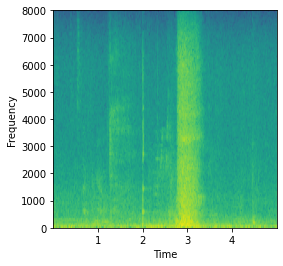

In [35]:
#@markdown Record or Upload Audio

record_or_upload = "Record" #@param ["Record", "Upload (.mp3 or .wav)"]

record_seconds =   5#@param {type:"number", min:1, max:10, step:1}

if record_or_upload == "Record":
    audio = recorder()
# else:
  # Load audio sample here (.mp3 or .wav3 file)
  # Just use the first file.
#   file/names, audios = upload()
#   audio = audios[0]

# Add batch dimension
audio = audio[np.newaxis, :]

# Listen.
Myspecplot(audio)
playsound(audio)

Flanger
Chorus
Vibrato


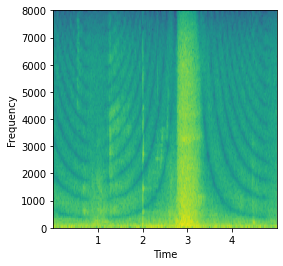

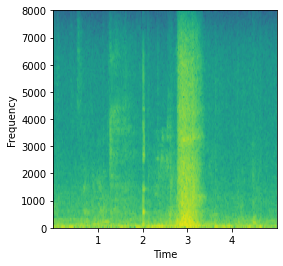

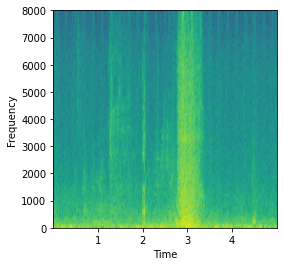

In [37]:
def sin_phase(mod_rate):
    """Helper function."""
    n_samples = audio.size
    n_seconds = n_samples / sample_rate
    phase = tf.sin(tf.linspace(0.0, mod_rate * n_seconds * 2.0 * np.pi, n_samples))
    return phase[tf.newaxis, :, tf.newaxis]

def modulate_audio(audio, center_ms, depth_ms, mod_rate):
    mod_delay = ddsp.effects.ModDelay(center_ms=center_ms,
                                      depth_ms=depth_ms,
                                      gain_scale_fn=None,
                                      phase_scale_fn=None)

    phase = sin_phase(mod_rate)  # Hz
    gain = 1.0 * np.ones_like(audio)[..., np.newaxis]
    audio_out = 0.5 * mod_delay(audio, gain, phase)

    # Listen.
    playsound(audio_out)
    Myspecplot(audio_out)

# Three different effects.
print('Flanger')
modulate_audio(audio, center_ms=0.75, depth_ms=0.75, mod_rate=0.25)

print('Chorus')
modulate_audio(audio, center_ms=25.0, depth_ms=1.0, mod_rate=2.0)

print('Vibrato')
modulate_audio(audio, center_ms=25.0, depth_ms=12.5, mod_rate=5.0)
